In [1]:
import scipy.special as sp
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def mapli(f,x):
    return list(map(f,x))

def mapar(f,x):
    return np.array(list(map(f,x)))

In [3]:
## module newtonPoly
''' p = evalPoly(a,xData,x).
    Evaluates Newton’s polynomial p at x. The coefficient
    vector {a} can be computed by the function ’coeffts’.
    a = coeffts(xData,yData).
    Computes the coefficients of Newton’s polynomial.
'''
def evalPoly(a,xData,x):
    n = len(xData) - 1  # Degree of polynomial
    p = a[n]
    for k in range(1,n+1):
        p = a[n-k] + (x -xData[n-k])*p
    return p
def coeffts(xData,yData):
    m = len(xData)  # Number of data points
    a = yData.copy()
    for k in range(1,m):
        a[k:m] = (a[k:m] - a[k-1])/(xData[k:m] - xData[k-1])
    return a



## module neville
''' p = neville(xData,yData,x).
    Evaluates the polynomial interpolant p(x) that passes
    through the specified data points by Neville’s method.
'''
def neville(xData,yData,x):
    m = len(xData)   # number of data points
    y = yData.copy()
    for k in range(1,m):
        y[0:m-k] = ((x - xData[k:m])*y[0:m-k] +      \
                    (xData[0:m-k] - x)*y[1:m-k+1])/  \
                    (xData[0:m-k] - xData[k:m])
    return y[0]





## module rational
''' p = rational(xData,yData,x)
    Evaluates the diagonal rational function interpolant p(x)
    that passes through the data points
'''
import numpy as np

def rational(xData,yData,x):
    m = len(xData)
    r = yData.copy()
    rOld = np.zeros(m)
    for k in range(m-1):
        for i in range(m-k-1):
            if abs(x - xData[i+k+1]) < 1.0e-9:
                return yData[i+k+1]
            else:
                c1 = r[i+1] - r[i]
                c2 = r[i+1] - rOld[i+1]
                c3 = (x - xData[i])/(x - xData[i+k+1])
                r[i] = r[i+1] + c1/(c3*(1.0 - c1/c2) - 1.0)
                rOld[i+1] = r[i+1]
    return r[0]



## module LUdecomp3
''' c,d,e = LUdecomp3(c,d,e).
    LU decomposition of tridiagonal matrix [c\d\e]. On output
    {c},{d} and {e} are the diagonals of the decomposed matrix.
x = LUsolve(c,d,e,b).
Solves [c\d\e]{x} = {b}, where {c}, {d} and {e} are the
vectors returned from LUdecomp3.
'''

def LUdecomp3(c,d,e):
    n = len(d)
    for k in range(1,n):
        lam = c[k-1]/d[k-1]
        d[k] = d[k] - lam*e[k-1]
        c[k-1] = lam
    return c,d,e

def LUsolve3(c,d,e,b):
    n = len(d)
    for k in range(1,n):
        b[k] = b[k] - c[k-1]*b[k-1]
    b[n-1] = b[n-1]/d[n-1]
    for k in range(n-2,-1,-1):
        b[k] = (b[k] - e[k]*b[k+1])/d[k]
    return b




## module cubicSpline
''' k = curvatures(xData,yData).
    Returns the curvatures of cubic spline at its knots.
    y = evalSpline(xData,yData,k,x).
    Evaluates cubic spline at x. The curvatures k can be
    computed with the function ’curvatures’.
'''

import numpy as np
#from LUdecomp3 import *
def curvatures(xData,yData):
    n = len(xData) - 1
    c = np.zeros(n)
    d = np.ones(n+1)
    e = np.zeros(n)
    k = np.zeros(n+1)
    c[0:n-1] = xData[0:n-1] - xData[1:n]
    d[1:n] = 2.0*(xData[0:n-1] - xData[2:n+1])
    e[1:n] = xData[1:n] - xData[2:n+1]
    k[1:n] =6.0*(yData[0:n-1] - yData[1:n]) \
                 /(xData[0:n-1] - xData[1:n]) \
             -6.0*(yData[1:n] - yData[2:n+1])   \
                 /(xData[1:n] - xData[2:n+1])
    LUdecomp3(c,d,e)
    LUsolve3(c,d,e,k)
    return k




def evalSpline(xData,yData,k,x):
    
    def findSegment(xData,x):
        iLeft = 0
        iRight = len(xData) - 1
        while 1:
            if (iRight-iLeft) <= 1: 
                return iLeft           
            i = round((iLeft + iRight)/2)
#            print('i ',i, 'x ',x,' xData[i]', xData[i])
            if x < xData[i] : 
                iRight = i
            else: 
                iLeft = i
                
    i = findSegment(xData,x)
    h = xData[i] - xData[i+1]
    y = ((x - xData[i+1])**3/h - (x - xData[i+1])*h)*k[i]/6.0   \
        - ((x - xData[i])**3/h - (x - xData[i])*h)*k[i+1]/6.0   \
        + (yData[i]*(x - xData[i+1]) - yData[i+1]*(x - xData[i]))/h
    return y



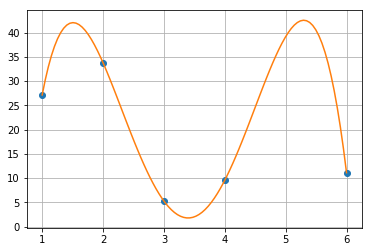

In [6]:
## neville fitting

#xar = np.array([1, 2.5, 3.5, 4.5, 1.1, 1.8, 2.2, 3.7])
#yar = np.array([6.008,15.722,27.130,33.772,5.257,9.549,11.098,28.828])

xar = np.array([1,2,3,4,6])
yar = np.array([27.130,33.772,5.257,9.549,11.098])

#xx   = np.linspace(1,4.5,100)
xx = np.linspace(1,6,100)
xlen = (len(xx))
yy   = np.zeros(xlen)

ncount = 0
#for x in xx:
#    yy[ncount] = neville(xar,yar,x)
#    ncount += 1

yy = mapar(lambda x:neville(xar,yar,x),xx)

plt.plot(xar,yar,'o',xx,yy,'-')
plt.grid()
plt.show()

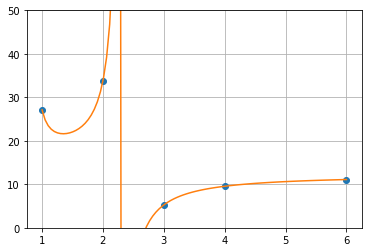

In [7]:
## rational fitting

#xar = np.array([1, 2.5, 3.5, 4.5, 1.1, 1.8, 2.2, 3.7])
#yar = np.array([6.008,15.722,27.130,33.772,5.257,9.549,11.098,28.828])

xar = np.array([1,2,3,4,6])
yar = np.array([27.130,33.772,5.257,9.549,11.098])

#xx   = np.linspace(1,4.5,100)
xx = np.linspace(1,6,100)
xlen = (len(xx))
yy   = np.zeros(xlen)

ncount = 0
#for x in xx:
#    yy[ncount] = rational(xar,yar,x)
#    ncount += 1

yy = mapar(lambda x:rational(xar,yar,x),xx)

plt.plot(xar,yar,'o',xx,yy,'-')
plt.ylim(0,50)
plt.grid()
plt.show()

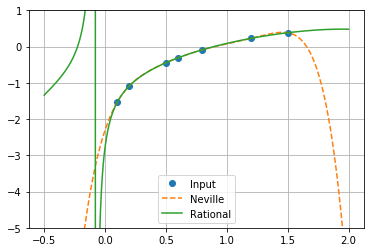

In [8]:
xData = np.array([0.1,0.2,0.5,0.6,0.8,1.2,1.5])
yData = np.array([-1.5342,-1.0811,-0.4445,-0.3085, -0.0868,0.2281,0.3824])

x = np.linspace(-0.5,2,1000)

nev = mapar(lambda x:neville(xData,yData,x),x)
rat = mapar(lambda x:rational(xData,yData,x),x)

plt.ylim(-5,1)
plt.plot(xData,yData,'o',x,nev,'--',x,rat,'-')
plt.legend(['Input','Neville','Rational'])
plt.grid()
plt.show()

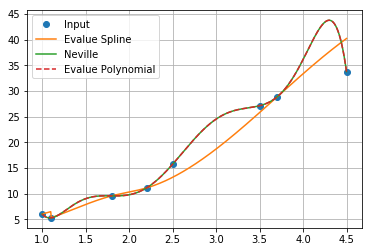

In [9]:
xar = np.array([1, 2.5, 3.5, 4.5, 1.1, 1.8, 2.2, 3.7])
#xar = np.array([1,2,3,4,5,6,7,8])
yar = np.array([6.008,15.722,27.130,33.772,5.257,9.549,11.098,28.828])

x = np.linspace(1,4.5,500)

a = coeffts(xar,yar)
k = curvatures(xar,yar)

pol = mapar(lambda x:evalPoly(a,xar,x),x)
nev = mapar(lambda x:neville(xar,yar,x),x)
spl = mapar(lambda x:evalSpline(xar,yar,k,x),x)

#plt.ylim(0,50)
plt.plot(xar,yar,'o',x,spl,'-',x,nev,'-',x,pol,'--')
plt.legend(['Input','Evalue Spline','Neville','Evalue Polynomial'])
plt.grid()
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in double_scalars


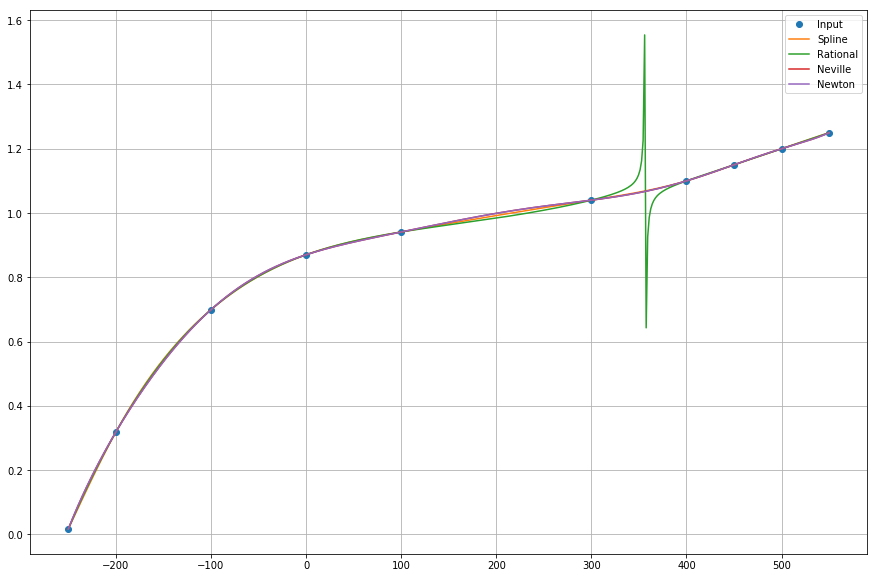

In [10]:
## Compare fitting done with Newton, Neville, rational and splines
## What is the optimal number of points for fitting the above data with a polynomial?

xData = np.array([-250,-200,-100,0,100,300,400,450,500,550])
yData = np.array([0.0163,0.318,0.699,0.870,0.941,1.04,1.1,1.15,1.2,1.25])

x = np.linspace(min(list(xData)),max(list(xData)),500)

a = coeffts(xData,yData)
k = curvatures(xData,yData)

pol = mapar(lambda x:evalPoly(a,xData,x),x)
nev = mapar(lambda x:neville(xData,yData,x),x)
rat = mapar(lambda x:rational(xData,yData,x),x)
spl = mapar(lambda x:evalSpline(xData,yData,k,x),x)

plt.figure(figsize=[15,10])

plt.plot(xData,yData,'o',x,spl,'-',x,rat,'-',x,nev,'-',x,pol,'-')
plt.legend(['Input','Spline','Rational','Neville','Newton'])
plt.grid()
plt.show()

In [ ]:
## Compare fitting done with Newton, Neville, rational and splines
## What is the optimal number of points for fitting the above data with a polynomial?

xData = np.array([-250,-200,-100,0,100,300,400,450,500,550])
yData = np.array([0.0163,0.318,0.699,0.870,0.941,1.04,1.1,1.15,1.2,1.25])

x = np.linspace(min(list(xData)),max(list(xData)),500)

a = coeffts(xData,yData)
k = curvatures(xData,yData)

pol = mapar(lambda x:evalPoly(a,xData,x),x)
nev = mapar(lambda x:neville(xData,yData,x),x)
rat = mapar(lambda x:rational(xData,yData,x),x)
spl = mapar(lambda x:evalSpline(xData,yData,k,x),x)

plt.figure(figsize=[15,10])
plt.xlim(50,560)
plt.ylim(0.9,1.3)

plt.plot(xData,yData,'o',x,spl,'-',x,rat,'-',x,nev,'-',x,pol,'-')
plt.legend(['Input','Spline','Rational','Neville','Newton'])
plt.grid()
plt.show()

In [ ]:
x = np.linspace(-5,5,2000)
y = mapar(sp.gamma,x)

plt.plot(x,y,'-')
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()

In [ ]:
x = np.linspace(-5,5,2000)
y = mapar(sp.erf,x)

plt.plot(x,y,'-')
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()

In [ ]:
a = np.array([1,2,3])
b = a

a[0] = 3
b[2] = 1

print(a,b)

In [ ]:
a = np.array([1,2,3])
b = a.copy()

a[0] = 3
b[2] = 1

print(a,b)